# Quinine: Main Paper Figure 2

In [1]:
# Some magic functions
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Defining Paths

These paths provide access to the 2DJ dataset, and an output directory.

In [2]:
from pathlib import Path

root = Path("../../")
molecule = "quinine"

# Path to the 2DJ dataset
# Under this directory, NMR-EsPy expects a ser file, an acqus file, and an acqu2s file to exist
data_dir = root / "data" / molecule / "1"

# Directory which results will be output to
output_dir = root / "code" / molecule / "output"
output_dir.mkdir(exist_ok=True, parents=True)

## Importing and pre-processing the data

In the cell below, the following is carried out (see the `else` block):

1. The 2DJ dataset is loaded into NMR-EsPy using `new_bruker`
2. The dataset is phased in the direct-dimension
3. Baseline correction is applied to the direct-dimension signals

It is possible to store estimator objects using Python's "pickling" protocol with the `to_pickle()` method. These can be reloaded at a future time using `from_pickle()` (this is a classmethod).
This cell uses a control statement to load a pre-saved estimator object if one already exists, and to create a new one and subsequently save it if one den't exist yet.

In [3]:
import nmrespy as ne

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_dir)
    estimator.phase_data(p0=1.803, p1=-6.239)
    estimator.baseline_correction()
    estimator.to_pickle(estimator_path)

Saved file ../../code/quinine/output/estimator.pkl.


## Estimation

The try-except block checks whether the estimator already contains results (these are stored in the `_results` attribute). If there are results present, the estimation routine is skipped to save time. If there are no results, a `ValueError` is raised. If this is caught, the estimation routine is run. If you wish to re-run the estimation, even if results have already been generated, set `rerun_estimation` to `True`. This will erase all previously stored results.

A list of 2-tuples indicating the regions to estimate is provided, along with additional parameters, contained in the `estimate_kwargs` dictionary:

* `noise_region` - Defines a region deviod of signals which is used to estimate the noise variance. This is made use of in the frequency filtration. As this involves generating random noise, I have fixed the seed of the random number generator to ensure each time the estimation is run, excatly the same result is obtained. I intend to change the filtration procedure in the future, which will mean that a noise region is no longer required.
* `region_unit` - Specifies the unit that the regions are given in (`"ppm"` or `"hz"` are accepted).
* `check_neg_amps_every` - After a multiple of this number of iterations has been performed, the parameter set is checked for the presence of negative amplitudes. If any are found, they are removed from the parameter set, and the optimisation is re-started. This acts to remove spurious/extranous signals from the model.
* `max_iterations` - The largest permitted number of iterations before the routine is terminated.

### Saving the Estimator

Note that it is a good idea to save the estimator after the completion of each call to `estimate` to ensure data loss is not incurred, using the `to_pickle()` method. If multiple regions have already been estimated, and an error subsequently arises, the program will crash and all the results will cleaned up from the RAM! `force_overwrite` has been set to `True` to avoid being manually prompted to confirm you are happy overwriting an existing file.

### Providing a Model Order Guess

In some cases, it can be beneficial to provided a hard-coded estimate of the number of signals that the region of interest comprises. This is most commonly necessary when the automated model order selection routine, which makes use of the Minimum Description Length criterion (MDL), outputs an underestimate for regions that are highly crowded, though there are also cases where an overestimate can be made (see the dexamethasone notebook). The model order can be hard-coded by setting the `initial_guess` kwarg to an integer value. This has been applied to two of the regions in this example: 5 - 4.85 ppm and 2 - 1.7 ppm. 
By commenting out the lines

    initial_guesses[1] = 17
    initial_guesses[5] = 36
    
you can see how the estimation compares when relying on the MDL.

In [4]:
import numpy as np
np.random.seed(0)

rerun_estimation = False

try:
    if rerun_estimation:
        raise ValueError("Re-running estimation.")
    estimator.get_results()
    
except ValueError:
    regions = [
        (5.8, 5.55),
        (5., 4.85),
        (3.75, 3.63),
        (3.17, 3.06),
        (2.8, 2.6),
        (2.0, 1.7),
        (1.64, 1.52),
        (1.52, 1.40),
    ]
    estimate_kwargs = dict(
        noise_region=(10.2, 10.0),
        region_unit="ppm",
        check_neg_amps_every=100,
        max_iterations=500,
    )
    initial_guesses = len(regions) * [None]
    initial_guesses[1] = 17
    initial_guesses[5] = 36 
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess, 
            **estimate_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌──────────────────────────────────────┐
│ESTIMATING REGION: 5.8 - 5.55 ppm (F2)│
└──────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 18
--> Pencil parameters: 64, 75
--> Enhanced Block Hankel matrix constructed:
	Size: 4800 x 4940
	Memory: 0.3533GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 7 secs, 693 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.723091     │ 1.92945      │ 1      

## Plotting the Result

The following cell provides a function which generates a figure outlining the estimation result using the estimator's `plot_result` method. A large number of kwargs are provided to adjust the aesthetics of the figure, with a detailed summary [here](https://foroozandehgroup.github.io/NMR-EsPy/references/estimator2dj.html#nmrespy.Estimator2DJ.plot_result).

### Predicting Multiplets

Once the estimation routine is complete, it is possible to group signals in the fit model to form multiplets. The grouping relies on the fact that for a given multiplet, all signals should have the same "central frequency", defined as 
$$f_{\text{c}} = f^{(2)} - f^{(1)},$$
where $f^{(1)}$ and $f^{(2)}$ are the indirect- and direct-dimension frequencies of a given signal, respectively. To account for error in the experiment and estimation, all signals for which the above criterion is the same within an appropriate threshold are deemed to be in the same multiplet.
A default threshold is defined, and accessbile via `estimator.default_multiplet_thold`, which is given by
$$\max(f^{(1)}_{\text{sw}} / N^{(1)}, f^{(2)}_{\text{sw}} / N^{(2)}),$$
i.e. the digital resolution in the more poorly resolved dimension.
This can sometimes be too small, with signals which clearly belong to the same multiplet strcture being classified incorrectly.
There are a few methods, including `plot_result()` and `predict_multiplets()`, where a custom threshold can be supplied. This isn't needed here though since the default threshold is being used.

In [5]:
print("Default multiplet threshold: {:.3f} Hz".format(estimator.default_multiplet_thold))

Default multiplet threshold: 0.923 Hz


In [6]:
import copy
import matplotlib.pyplot as plt

# Define colours for multiplets
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[:4]
# Add gray to denote signals that are not related to quinine first-orer multiplets
colors.append("#808080")

def get_colors(mp_indices):
    return [colors[i] for i in mp_indices]
    
default_plot_kwargs= dict(
    region_unit="ppm",
    xaxis_ticks = [
        (0, [5.8, 5.7, 5.6]),
        (2, [3.7]),
        (3, [3.1]),
        (4, [2.7]),
        (5, [1.9, 1.8]),
    ],
    multiplet_lw=0.8,
    marker_size=15.0,
    figsize=(8.0, 5.0),
    axes_left=0.1,
    axes_right=0.99,
    axes_bottom=0.11,
    axes_top=0.98,
    contour_base=4.0e3,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    lb=2.0,
    ratio_1d_2d=(3.0, 1.0),
)

def plot_result(estimator, **kwargs):
    plot_kwargs = copy.deepcopy(default_plot_kwargs)
    for key, value in kwargs.items():
        plot_kwargs[key] = value
    fig, axs = estimator.plot_result(**plot_kwargs)
    return fig, axs

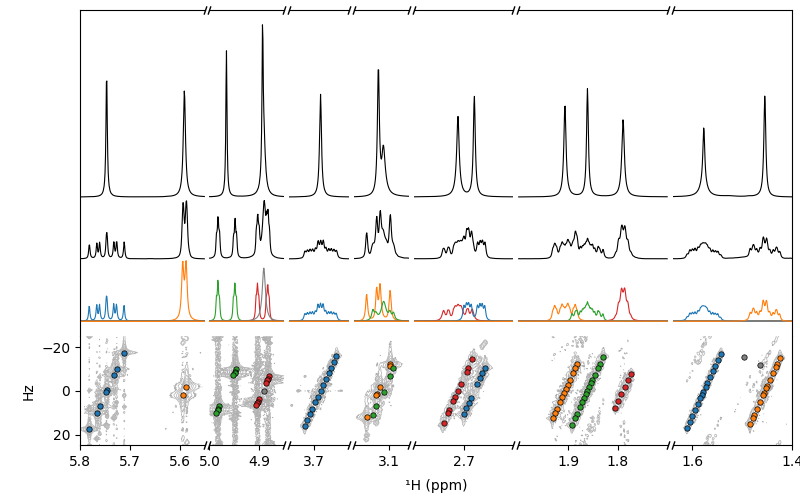

In [7]:
multiplet_colors = get_colors([0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 0, 4, 4, 1])
plot_result(estimator, multiplet_colors=multiplet_colors);

## Removing Spurious Signals

Inscpecting the plot above, it can be seen that there are two fit signals which appear to be derived from strong coupling artifacts or noise. These signals and a suspected water signal at ~4.9ppm have been coloured grey, to indicate that they are not related to one of the first-order quinine multiplets.

The two grey signals at ~1.5ppm can be automatically removed from the result, by calling the `predict_multiplets` method, with the `rm_spurious` kwarg set to `True`. After grouping all the signals into multiplets, any grouping with the following criteria are marked for removal from the result:

1. The grouping contains a single signal.
2. The indirect-dimension frequency of the signal has a magnitude which is larger than the multiplet threshold (see above).

Any groupings that fulfil these criteria are likely to contain a fit signal which is unrelated to the first-order signals in the 2DJ data. The water signal remains since it has an indirect-dimension frequency which is very close to 0Hz.

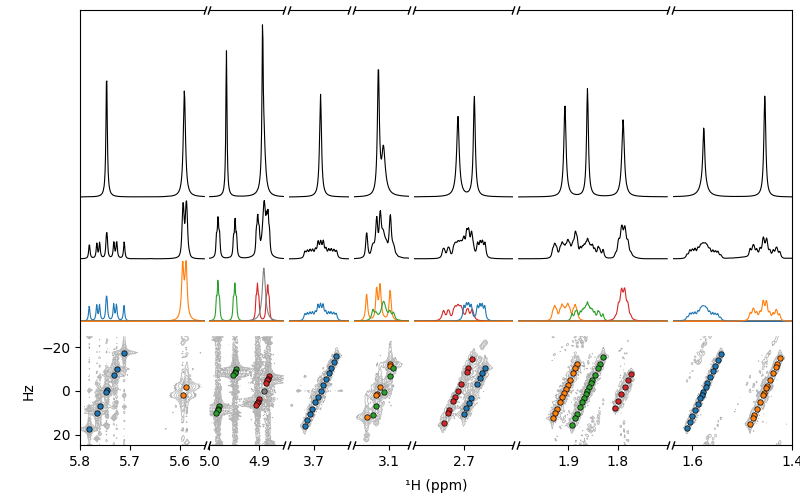

In [8]:
multiplet_colors = get_colors([0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1])
estimator.predict_multiplets(rm_spurious=True)
plot_result(estimator, multiplet_colors=multiplet_colors);

## Removing the Water Signal

Desipte it being very close to the red multiplet structure around 4.9 ppm, it was possible to separate out the water signal (gray). The separation between the multiplet and the water is as follows:

In [9]:
mp_freq, water_freq = list(estimator.predict_multiplets(indices=[1]).keys())[:2]
print("Multiplet central frequency: {:.3f} Hz".format(mp_freq))
print("Water frequency: {:.3f} Hz".format(water_freq))
print("Difference: {:.4f} Hz".format(abs(mp_freq - water_freq)))

Multiplet central frequency: 2445.969 Hz
Water frequency: 2447.234 Hz
Difference: 1.2647 Hz


This can manually be removed, which will result in a clean peak in the final CUPID spectrum. This can be achieved as follows:

1. Determine the index of the water signal. Using `predict_multiplets()` with `indices=[1]` returns the multipets in the 2nd (5 - 4.85 ppm) result (remember indexing starts from 0!).

In [10]:
result_1_multiplets = estimator.predict_multiplets(indices=[1])
sfo = estimator.sfo[1]
for freq, indices in result_1_multiplets.items():
    print("{:.3f} ppm : {}".format(freq / sfo, indices))

4.891 ppm : [4]
4.893 ppm : [0, 1, 2, 3, 5, 6, 7, 8]
4.966 ppm : [9, 10, 11, 12, 13, 14, 15, 16]


From this, we can see that the water signal corresponds to index `4`.

2. Call `remove_oscillators()` as follows:

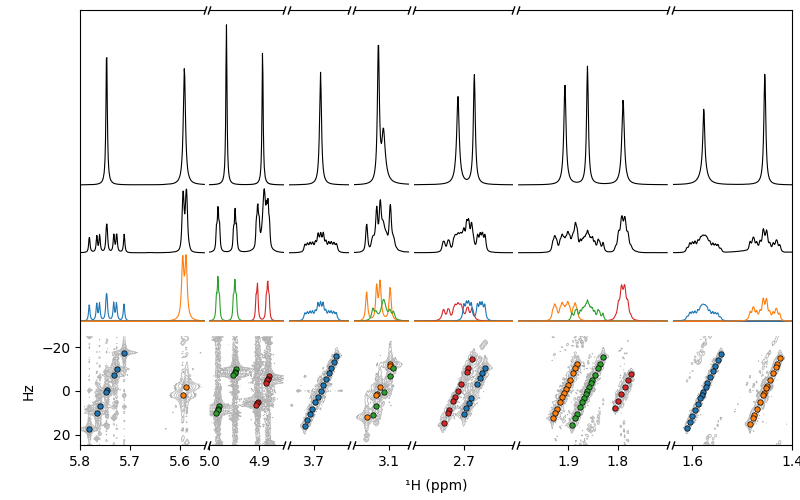

In [12]:
estimator.remove_oscillators(index=1, osc_indices=[4])

multiplet_colors = get_colors([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1])
plot_result(estimator, multiplet_colors=multiplet_colors);